# Linear regression

Model trying to predict value of a variable($y_i$) using a linear relationship with another variable($x$) or variables<br>
$$\hat y_i = b_0 + b_1x$$
where $\hat y_i$ is the predicted value<br>

residual: absolute of (predicted value minus the actual value) $|\hat y_i - y_i|$<br><br>
We're trying to minimise sum of the residuals $\min(\sum_i|\hat y_i - y_i|)$<br>
We could also attribute a squared residual penalty for a model and try to minimise that $\min(\sum_i(\hat y_i - y_i)^2)$<br>

simple linear regression: $y_i = b_0 + b_1x$<br>
multiple linear regression: $y_i = b_0 + b_1x_0 + b_2x_1 + ... b_nx_{n-1}$<br>

Assumptions for modelling with linear regression:
 - linearity: (y should be linearly distributed w.r.t x)
 - independence: there is no relationship between y and residuals
 - normality: the residuals plot w.r.t. x must be normally distributed
 - homoscedasticity: the residual plot w.r.t. x must have equal variances across different sections

### Evaluating linear regression

#### Mean absolute error
$\dfrac{\sum_i^n|\hat y_i - y_i|}{n}$<br>

#### Mean squared error
$\dfrac{\sum_i^n(\hat y_i - y_i)^2}{n}$<br>

#### Root Mean squared error
$\sqrt{\dfrac{\sum_i^n(\hat y_i - y_i)^2}{n}}$<br>

#### $R^2$ - Coff. of determination
$R^2 = 1 - \dfrac{RSS}{TSS}$<br>
where RSS is the sum of squared residuals<br>
$RSS = \sum_{i = 1}^{n}(y_i - \hat y_i)^2$
and TSS is the total sum of squares<br>
$TSS = \sum_{i = 1}^{n}(y_i - \bar y_i)^2$, where $\bar y_i$ is the mean of $y_i$s

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

# Dataset:

https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

In [3]:
cols = ["date", "bike_count", "hour", "temp", "humidity", "wind_speed", "visibility", "dew_point", "solar_radiation", "rainfall", "snowfall", "season", "holiday", "functional_day"]
df = pd.read_csv("seoul_bike_demand/SeoulBikeData.csv")
df.columns = cols
df["season"] = df["season"].astype('category').cat.codes
df["holiday"] = (df["holiday"] == "No Holiday").astype(int)
df["functional_day"] = (df["functional_day"] == "Yes").astype(int)
df = df.drop("date", axis = 1)

In [4]:
df8 = df[df["hour"] == 8]
df8 = df8.drop("hour", axis = 1)

df12 = df[df["hour"] == 12]
df12 = df12.drop("hour", axis = 1)

df16 = df[df["hour"] == 16]
df16 = df16.drop("hour", axis = 1)

df20 = df[df["hour"] == 20]
df20 = df20.drop("hour", axis = 1)
df20.head()

df_hour = {8: df8, 12: df12, 16: df16, 20: df20}


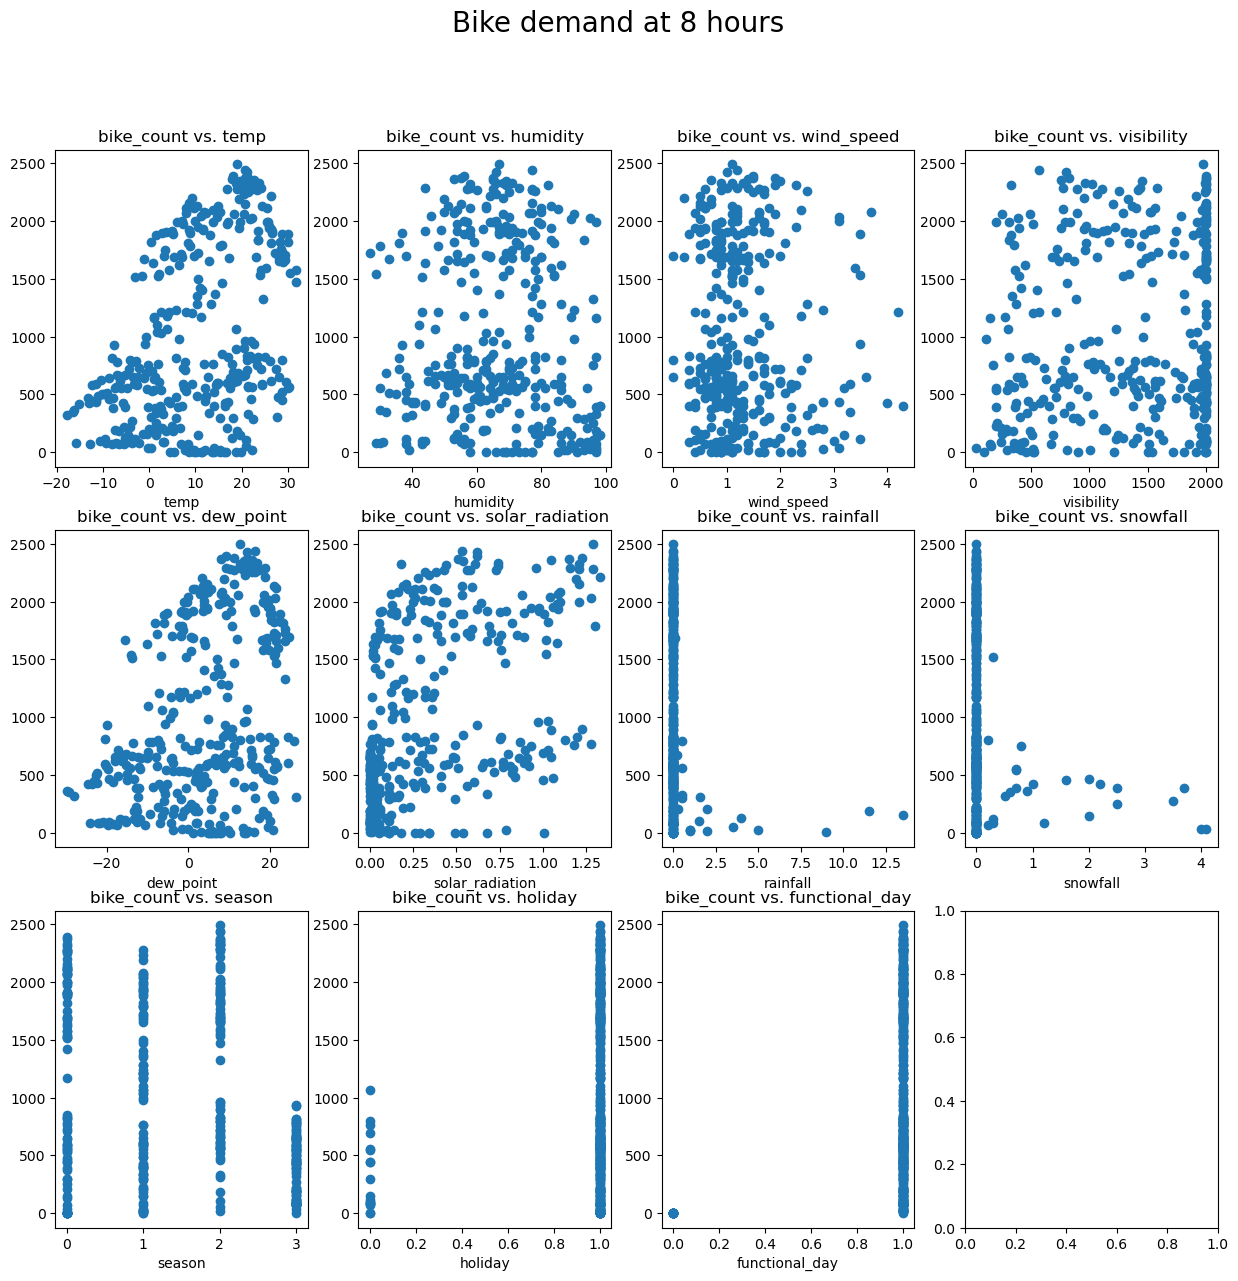

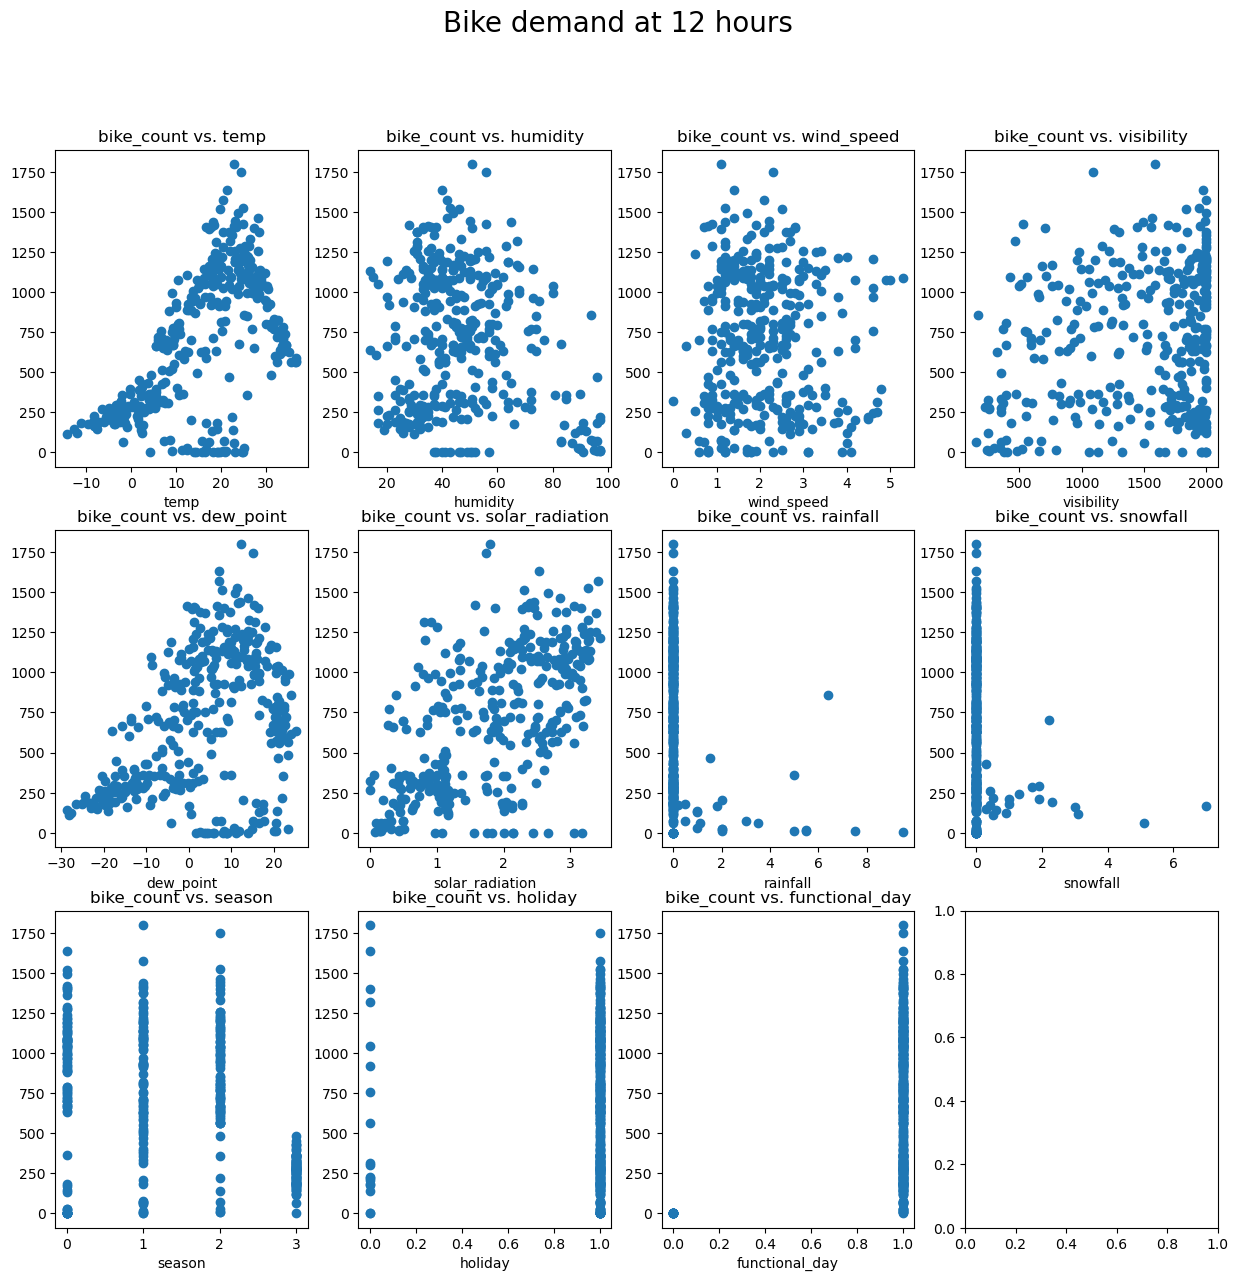

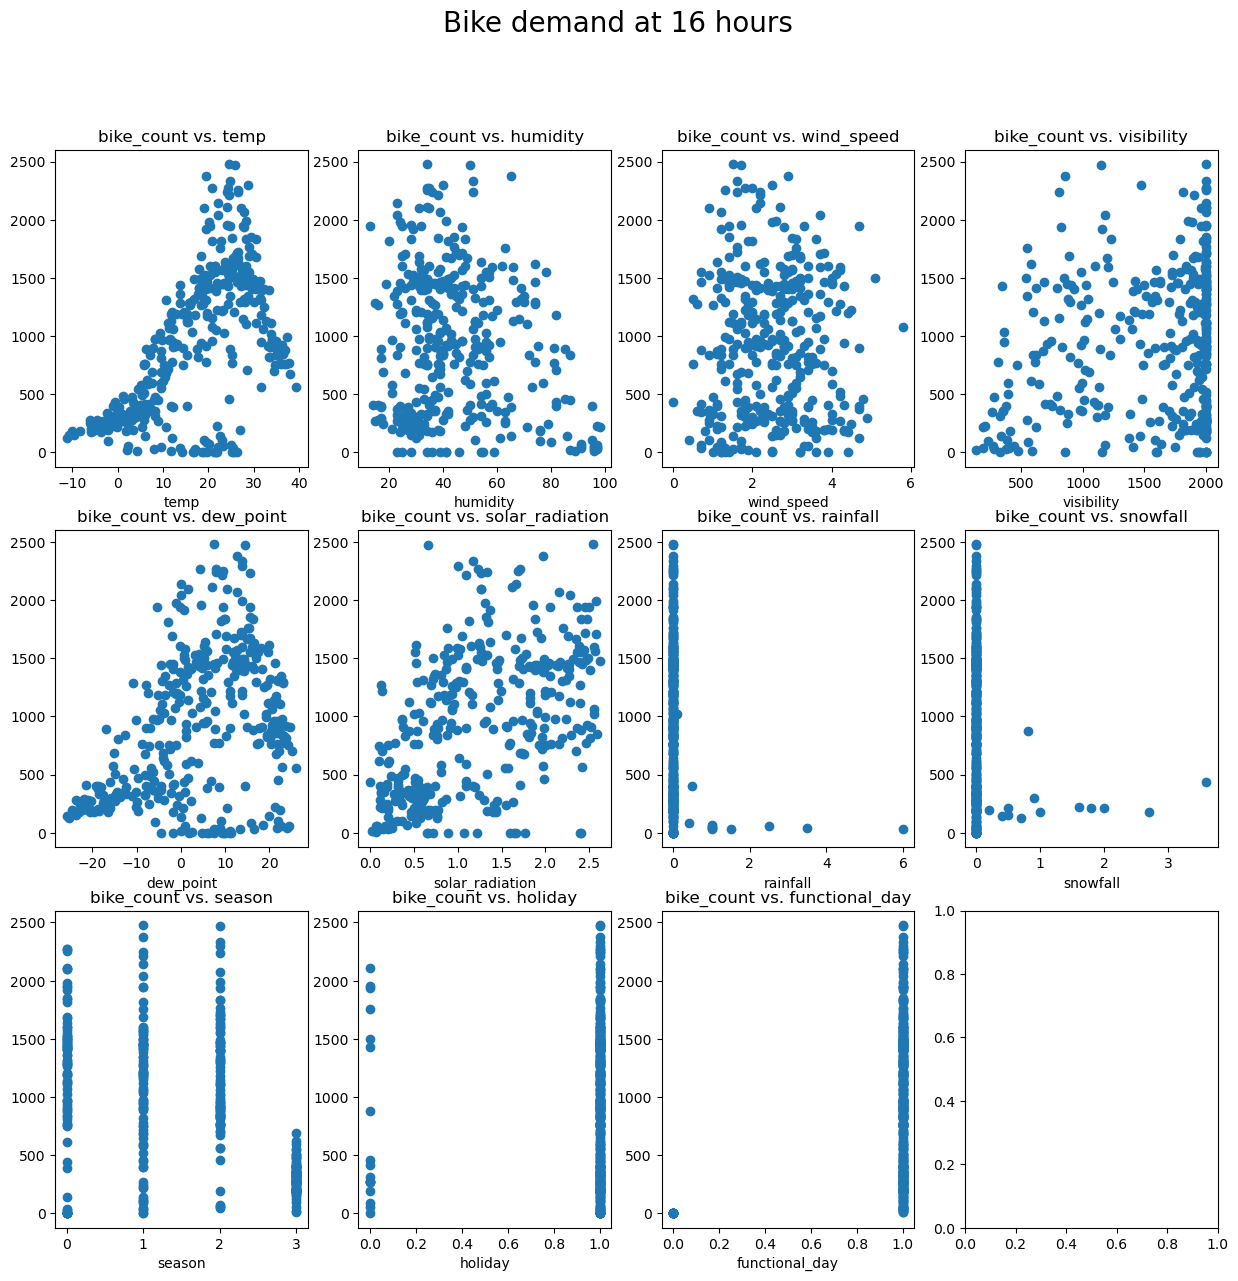

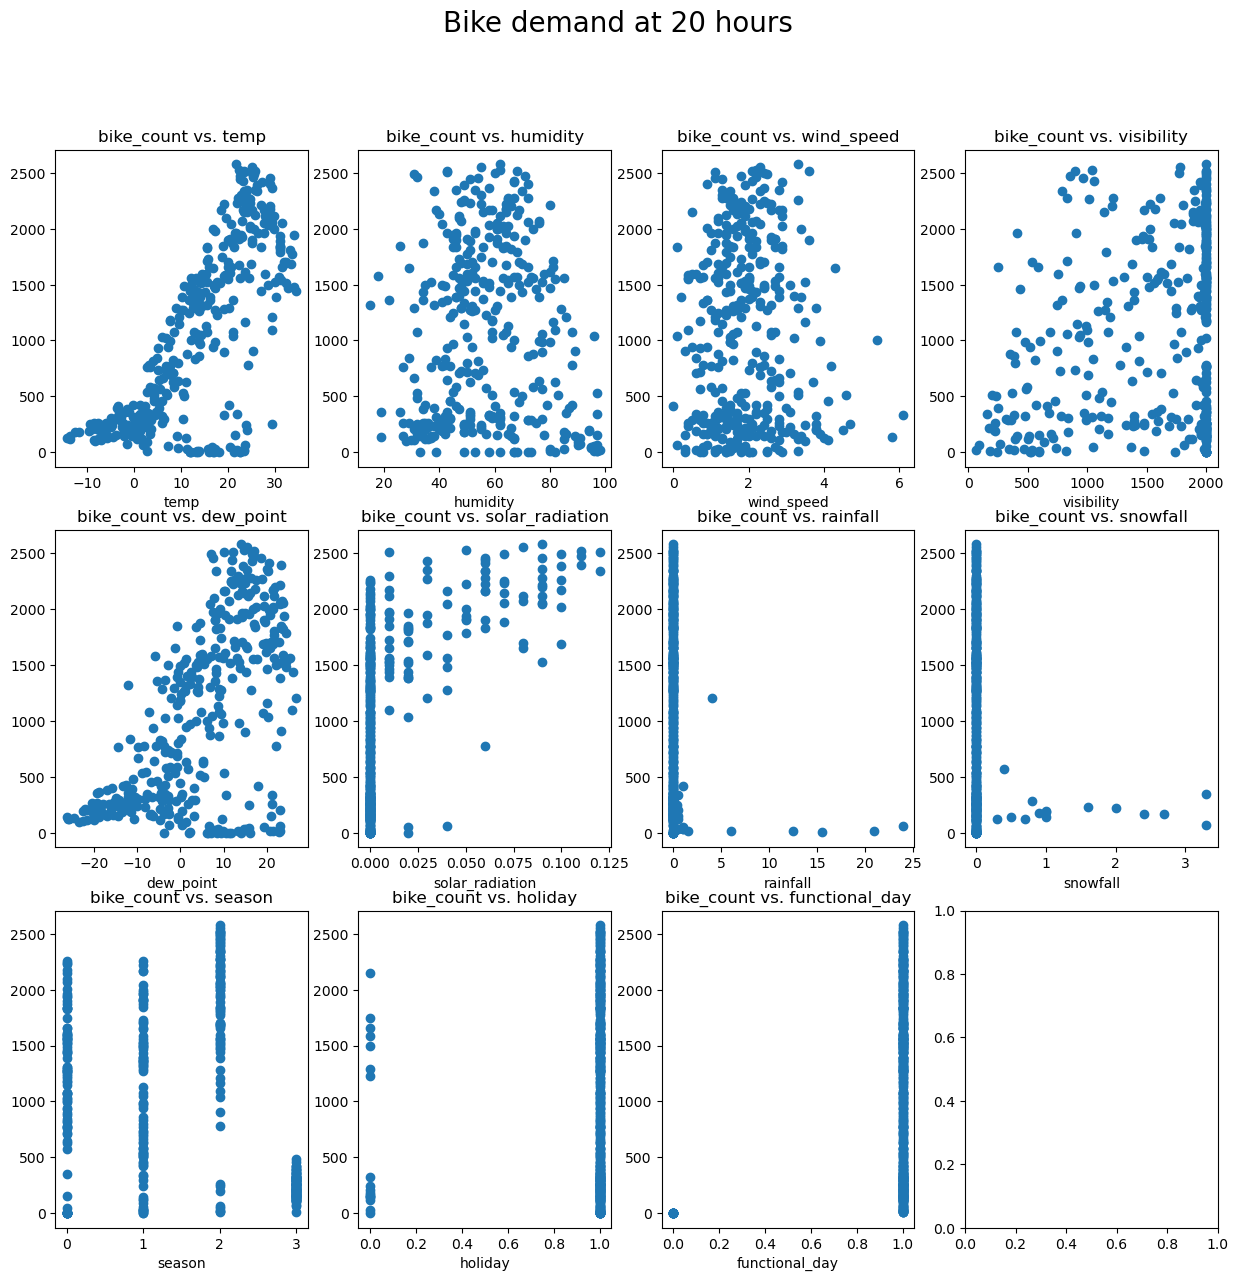

In [5]:
for hour, dfi in df_hour.items():
    fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize = (15, 14))
    for idx, labl in enumerate(dfi.columns[:].drop('bike_count')):
        axs[int(idx / 4)][int(idx % 4)].scatter(x = dfi[labl], y = dfi['bike_count'])
        axs[int(idx / 4)][int(idx % 4)].set_title(f"bike_count vs. {labl}")
        axs[int(idx / 4)][int(idx % 4)].set_xlabel(f"{labl}")
    fig.suptitle(f"Bike demand at {hour} hours", size = 20)
    plt.show()

In [6]:
corrcoeff_df8 = df8.corr()
corrcoeff_df12 = df12.corr()
corrcoeff_df16 = df16.corr()
corrcoeff_df20 = df20.corr()

In [7]:
corrcoeff_df8.style.background_gradient(cmap='coolwarm')

,bike_count,temp,humidity,wind_speed,visibility,dew_point,solar_radiation,rainfall,snowfall,season,holiday,functional_day
bike_count,1.000000,0.437214,-0.060880,-0.053699,0.096100,0.370669,0.468237,-0.169331,-0.191887,-0.278923,0.199802,0.246230
temp,0.437214,1.000000,0.290248,-0.155285,-0.048334,0.960525,0.657961,0.088596,-0.238318,-0.315636,0.052353,-0.040858
humidity,-0.060880,0.290248,1.000000,-0.096716,-0.594026,0.542424,-0.199352,0.255220,0.157538,-0.210508,0.062348,-0.051102
wind_speed,-0.053699,-0.155285,-0.096716,1.000000,0.191636,-0.163474,-0.066823,0.010562,0.083848,0.085048,-0.017714,0.013522
visibility,0.096100,-0.048334,-0.594026,0.191636,1.000000,-0.207778,0.160839,-0.089976,-0.162976,0.029293,-0.061191,-0.043631
dew_point,0.370669,0.960525,0.542424,-0.163474,-0.207778,1.000000,0.520625,0.145253,-0.171375,-0.335148,0.064184,-0.053192
solar_radiation,0.468237,0.657961,-0.199352,-0.066823,0.160839,0.520625,1.000000,-0.107099,-0.184529,-0.137194,0.029690,-0.005696
rainfall,-0.169331,0.088596,0.255220,0.010562,-0.089976,0.145253,-0.107099,1.000000,-0.029330,-0.051151,0.033046,0.026752
snowfall,-0.191887,-0.238318,0.157538,0.083848,-0.162976,-0.171375,-0.184529,-0.029330,1.000000,0.171466,-0.002558,0.037271
season,-0.278923,-0.315636,-0.210508,0.085048,0.029293,-0.335148,-0.137194,-0.051151,0.171466,1.000000,-0.046259,0.219929


In [8]:
corrcoeff_df12.style.background_gradient(cmap='coolwarm')

,bike_count,temp,humidity,wind_speed,visibility,dew_point,solar_radiation,rainfall,snowfall,season,holiday,functional_day
bike_count,1.000000,0.575211,-0.188074,-0.027523,0.188548,0.409699,0.597940,-0.247522,-0.198729,-0.424458,0.041210,0.299803
temp,0.575211,1.000000,0.229197,-0.113212,0.073679,0.918104,0.489935,-0.016935,-0.230058,-0.367375,0.057574,-0.058438
humidity,-0.188074,0.229197,1.000000,-0.144052,-0.518132,0.586457,-0.496705,0.471135,0.118277,-0.108550,0.062659,0.015240
wind_speed,-0.027523,-0.113212,-0.144052,1.000000,0.179617,-0.143980,0.156786,-0.100312,-0.039109,0.081932,0.002129,-0.007575
visibility,0.188548,0.073679,-0.518132,0.179617,1.000000,-0.140933,0.332711,-0.310847,-0.069773,-0.050979,-0.035722,-0.032954
dew_point,0.409699,0.918104,0.586457,-0.143980,-0.140933,1.000000,0.210774,0.143391,-0.148141,-0.338890,0.076591,-0.050312
solar_radiation,0.597940,0.489935,-0.496705,0.156786,0.332711,0.210774,1.000000,-0.318929,-0.203318,-0.247010,-0.001109,-0.048171
rainfall,-0.247522,-0.016935,0.471135,-0.100312,-0.310847,0.143391,-0.318929,1.000000,0.059680,-0.017434,-0.081755,0.035699
snowfall,-0.198729,-0.230058,0.118277,-0.039109,-0.069773,-0.148141,-0.203318,0.059680,1.000000,0.111707,0.016718,0.031681
season,-0.424458,-0.367375,-0.108550,0.081932,-0.050979,-0.338890,-0.247010,-0.017434,0.111707,1.000000,-0.046259,0.219929


In [9]:
corrcoeff_df16.style.background_gradient(cmap='coolwarm')

,bike_count,temp,humidity,wind_speed,visibility,dew_point,solar_radiation,rainfall,snowfall,season,holiday,functional_day
bike_count,1.000000,0.583765,-0.190367,-0.001147,0.187588,0.408033,0.519554,-0.185141,-0.159552,-0.436707,0.052776,0.278017
temp,0.583765,1.000000,0.162160,-0.086422,0.051961,0.899879,0.572762,0.026424,-0.217967,-0.363063,0.064147,-0.057307
humidity,-0.190367,0.162160,1.000000,-0.252217,-0.541158,0.565851,-0.417270,0.339201,0.075831,-0.068190,0.052582,0.042831
wind_speed,-0.001147,-0.086422,-0.252217,1.000000,0.139454,-0.176781,0.297039,-0.122297,-0.068312,0.122693,-0.030544,0.012677
visibility,0.187588,0.051961,-0.541158,0.139454,1.000000,-0.185566,0.282404,-0.204840,-0.050336,-0.027193,-0.008286,-0.022448
dew_point,0.408033,0.899879,0.565851,-0.176781,-0.185566,1.000000,0.293891,0.145220,-0.147044,-0.321704,0.081503,-0.031487
solar_radiation,0.519554,0.572762,-0.417270,0.297039,0.282404,0.293891,1.000000,-0.178599,-0.146361,-0.144744,0.023070,-0.043542
rainfall,-0.185141,0.026424,0.339201,-0.122297,-0.204840,0.145220,-0.178599,1.000000,-0.019887,-0.081525,0.017365,0.024070
snowfall,-0.159552,-0.217967,0.075831,-0.068312,-0.050336,-0.147044,-0.146361,-0.019887,1.000000,0.097564,0.034695,0.028087
season,-0.436707,-0.363063,-0.068190,0.122693,-0.027193,-0.321704,-0.144744,-0.081525,0.097564,1.000000,-0.046259,0.219929


In [10]:
corrcoeff_df20.style.background_gradient(cmap='coolwarm')

,bike_count,temp,humidity,wind_speed,visibility,dew_point,solar_radiation,rainfall,snowfall,season,holiday,functional_day
bike_count,1.000000,0.743194,-0.066399,-0.002606,0.268646,0.610293,0.607358,-0.157004,-0.186276,-0.282142,0.102036,0.248596
temp,0.743194,1.000000,0.288911,-0.052561,0.068653,0.941018,0.523460,0.101253,-0.218889,-0.344993,0.065510,-0.048070
humidity,-0.066399,0.288911,1.000000,-0.129892,-0.544023,0.589514,0.069565,0.271491,0.140952,-0.098393,0.045651,-0.026137
wind_speed,-0.002606,-0.052561,-0.129892,1.000000,0.075970,-0.090019,0.051663,-0.069242,0.002843,0.042595,0.035010,0.065447
visibility,0.268646,0.068653,-0.544023,0.075970,1.000000,-0.122002,0.117407,-0.168902,-0.144564,-0.013219,-0.027310,0.017317
dew_point,0.610293,0.941018,0.589514,-0.090019,-0.122002,1.000000,0.469988,0.168772,-0.142996,-0.323071,0.067064,-0.051026
solar_radiation,0.607358,0.523460,0.069565,0.051663,0.117407,0.469988,1.000000,-0.007699,-0.082397,0.152701,0.074327,0.078447
rainfall,-0.157004,0.101253,0.271491,-0.069242,-0.168902,0.168772,-0.007699,1.000000,-0.021598,0.030991,0.025778,0.023437
snowfall,-0.186276,-0.218889,0.140952,0.002843,-0.144564,-0.142996,-0.082397,-0.021598,1.000000,0.152056,0.038698,0.031327
season,-0.282142,-0.344993,-0.098393,0.042595,-0.013219,-0.323071,0.152701,0.030991,0.152056,1.000000,-0.046259,0.219929


To avoid multicollinearity, I'm dropping `dew_point` from the dataframe

In [11]:
# df8 = df8.drop("dew_point", axis = 1)
# df12 = df12.drop("dew_point", axis = 1)
# df16 = df16.drop("dew_point", axis = 1)
# df20 = df20.drop("dew_point", axis = 1)

print(df20)

      bike_count  temp  humidity  wind_speed  visibility  dew_point  \
20           426  -0.3        79         1.5        1913       -3.5   
44           359   4.6        51         1.2        1585       -4.6   
68           397   5.2        87         1.4         253        3.2   
92           398  -3.6        38         3.0        2000      -15.8   
116          418  -3.5        46         0.0        2000      -13.4   
...          ...   ...       ...         ...         ...        ...   
8660         943   7.3        66         0.5         516        1.3   
8684         825   8.3        39         1.6         560       -4.8   
8708         842   4.8        29         0.6        1756      -11.7   
8732         818   4.1        54         1.3        1434       -4.3   
8756         764   3.4        37         2.3        2000       -9.9   

      solar_radiation  rainfall  snowfall  season  holiday  functional_day  
20                0.0       0.0       0.0       3        1            

In [12]:
train, validation, test = np.split(df.sample(frac = 1), [int(0.6 * len(df)), int(0.8 * len(df))])

In [36]:
def get_Xy(dataframe: pd.DataFrame, y_label, X_labels = None):
    dataframe = copy.deepcopy(dataframe)
    if not X_labels:
        X = dataframe[[c for c in cols if c != y_label]].to_numpy()
    else:
        X = dataframe[X_labels].to_numpy().reshape(-1, len(X_labels))
    y = dataframe[y_label].to_numpy().reshape(-1, 1)
    return np.hstack((X, y)), X, y

# print(get_Xy(train, y_label = "bike_count", X_labels = ["wind_speed", "rainfall"]))

In [37]:
_, X_train_temp, y_train_temp = get_Xy(dataframe = train, y_label = "bike_count", X_labels = ["temp"])
_, X_validation_temp, y_validation_temp = get_Xy(dataframe = validation, y_label = "bike_count", X_labels = ["temp"])
_, X_test_temp, y_test_temp = get_Xy(dataframe = test, y_label = "bike_count", X_labels = ["temp"])

In [38]:
temp_regression_model = LinearRegression()
temp_regression_model.fit(X = X_train_temp, y = y_train_temp)

LinearRegression()

In [39]:
print(temp_regression_model.coef_, temp_regression_model.intercept_)
temp_regression_model.score(X = X_test_temp, y = y_test_temp)

[[29.16957044]] [331.95664711]


0.2853053594057212

[[10.6]
 [-2.4]
 [ 3.6]
 ...
 [26.4]
 [ 4.7]
 [24.8]]
[[946]
 [ 53]
 [328]
 ...
 [  0]
 [819]
 [938]]


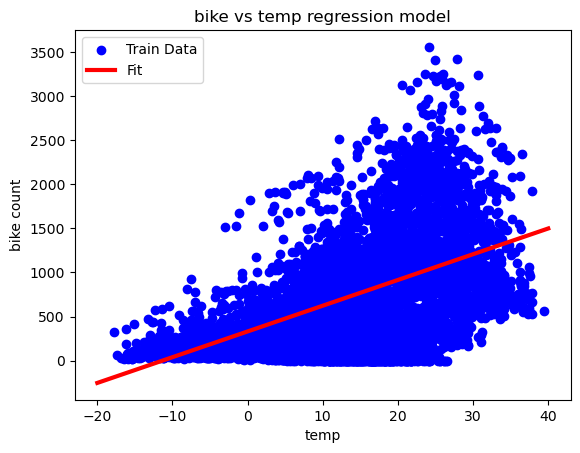

In [43]:
plt.scatter(x = X_train_temp, y = y_train_temp, label = "Train Data", color = "blue")
X_to_be_predicted_temp_regression_model = tf.linspace(-20, 40, 100) # predicting from -20 degrees to 40 degrees
print(X_train_temp)
print(y_train_temp)
# print(temp_regression_model.predict(X_to_be_predicted_temp_regression_model))
plt.plot(X_to_be_predicted_temp_regression_model, temp_regression_model.predict(np.array(X_to_be_predicted_temp_regression_model).reshape(-1, 1)), label = "Fit", color = "red", linewidth = 3) # np.array() and reshape() is for changing the input shape of x to the required shape, i.e. (len(feature_vector), 1)
plt.title("bike vs temp regression model")
plt.ylabel("bike count")
plt.xlabel("temp")
plt.legend()
plt.show()